In [155]:
import numpy as np
from numpy import random

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style('whitegrid')

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [133]:
from scipy.special import erfc
def H(x):
    return erfc(x/np.sqrt(2))/2

In [148]:
def SNR(signal, bias, D, overlap, m):
    return 1/2*(signal + bias/m) / np.sqrt(1/D/m + overlap + 1/D * m*(m-1)/m**4)

In [149]:
from jax import numpy as np

In [164]:
N = 500
D = 50
P = 5000

def few_shot_err(N,D,P,m,Ra,Rb):
    # Subspaces
    U = random.randn(N,2*(D+1))
    U,_ = np.linalg.qr(U)
    Ua,Ub,x0a,x0b = np.split(U,(D,2*D,2*D+1),axis=-1)
    x0a /= np.sqrt(2)
    x0b /= np.sqrt(2)

    # Training examples
    sa = random.randn(D,P,m)
    sa /= np.linalg.norm(sa,axis=0)
    sb = random.randn(D,P,m)
    sb /= np.linalg.norm(sb,axis=0)
    Xatrain = x0a + Ra*Ua@sa.mean(-1)
    Xbtrain = x0b + Rb*Ub@sb.mean(-1)
    Xtrain = np.stack([Xatrain,Xbtrain])

    # Testing examples
    ssa = random.randn(D,P)
    ssa /= np.linalg.norm(ssa,axis=0)
    ssb = random.randn(D,P)
    ssb /= np.linalg.norm(ssb,axis=0)
    Xatest = x0a + Ra*Ua@ssa
    Xbtest = x0b + Rb*Ub@ssb

    # Evaluate
    da = ((Xatest - Xtrain)**2).sum(1)
    db = ((Xbtest - Xtrain)**2).sum(1)
    erra = (da.argmin(0)!=0).mean()
    errb = (db.argmin(0)!=1).mean()
    err = (erra+errb)/2
    
    return err

In [153]:
ms = [1,3,5]
Rs = 1/np.linspace(0.4,0.8,20)
errs = []
for m in ms:
    for R in tqdm(Rs):
        Ra = Rb = R
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs = np.stack(errs).reshape(len(ms),len(Rs))

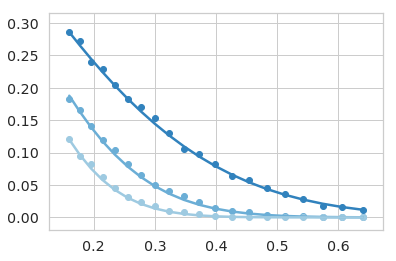

In [156]:
with sns.color_palette('tab20c'):
    for err,m in zip(errs,ms):
        plt.scatter((1/Rs)**2,err)
        bias = 0
        overlap = 0
        signals = (1/Rs)**2
        plt.plot(signals, H(SNR(signals, bias, D, overlap, m)))
#         plt.yscale('log')

In [175]:
ms = [1,3,5]
R = 2
Ra = Rb = R
Ds = np.linspace(10,200,20,dtype='int')
errs = []
for m in ms:
    for D in tqdm(Ds):
        err = few_shot_err(N,D,P,m,Ra,Rb)
        errs.append(err)
errs = np.stack(errs).reshape(len(ms),len(Ds))

Text(0.5, 0, 'D')

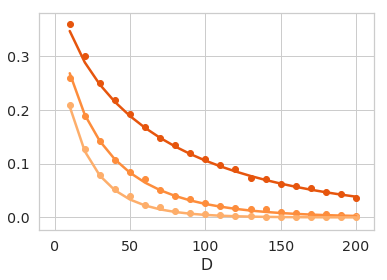

In [177]:
with sns.color_palette('tab20c'):
    for i in range(4):
        plt.scatter(0,0,s=0)
        plt.plot(0,0)
    for err,m in zip(errs,ms):
        plt.scatter(Ds,err)
        bias = 0
        overlap = 0
        signal = 1/R**2
        plt.plot(Ds, H(SNR(signal, bias, Ds, overlap, m)))
# plt.yscale('log')
plt.xlabel('D')